In [1]:
import pyidi
import os
import dill
import pickle
from sdypy import EMA
import numpy as np
import matplotlib.pyplot as plt 
from pixel_setter2 import PixelSetter
from scipy.signal import find_peaks
from pixel_setter import play_video
from scipy.spatial.distance import cdist
%matplotlib inline

c:\Users\thijsmas\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


### Import displacement data

In [2]:
# root_disp = 'C:/Users/thijs/Documents/GitHub/pyidi_data/displacements'
root_disp = 'C:/Users/thijsmas/Documents/GitHub/pyidi_data/'
file_name_basis = 'Full_web_ecc0_new_Floc4_v1'
file_name_displacemnet = file_name_basis + '_d'
extension = '.pkl'
path = os.path.join(root_disp, file_name_displacemnet + extension)

# Open displacement data
with open(path, 'rb') as f:
    # load the pickle data
    data = pickle.load(f)

# Open corresponding video
file_name_video = file_name_basis + "_S01.cihx"
folder_paths = ['D:/HSC', 'F:/', 'C:/Users/thijs/Documents/HSC/', 'H:/My Drive/PHD/HSC']  #, 'H:/My Drive/PHD/HSC'
for folder_path in folder_paths:
    for root, dirs, files in os.walk(folder_path, topdown=False):
        if file_name_video in files:
            file_path = os.path.join(root, file_name_video)
            print(file_path)
            break
video = pyidi.pyIDI(file_path)
fs_camera = video.info['Record Rate(fps)']
t_camera = np.arange(video.info['Total Frame']) / fs_camera
video.info

D:/HSC\ecc0\web0\Full_web_ecc0_new_Floc4_v1_S01\Full_web_ecc0_new_Floc4_v1_S01.cihx
H:/My Drive/PHD/HSC\ecc0\web0\Full_web_ecc0_new_Floc4_v1_S01\Full_web_ecc0_new_Floc4_v1_S01.cihx


c:\Users\thijsmas\AppData\Local\anaconda3\Lib\site-packages\pyMRAW.py:103: UserWarning: Clipped footage! (Total frame: 10000, Original total frame: 87371)
  warnings.warn('Clipped footage! (Total frame: {}, Original total frame: {})'.format(cih['Total Frame'], cih['Original Total Frame'] ))


{'Date': '2023/9/16',
 'Camera Type': 'FASTCAM SA-Z type 2100K-M-64GB',
 'Record Rate(fps)': 8000.0,
 'Shutter Speed(s)': 8104.0,
 'Total Frame': 10000,
 'Original Total Frame': 87371,
 'Image Width': 1024,
 'Image Height': 512,
 'File Format': 'Mraw',
 'EffectiveBit Depth': 12,
 'EffectiveBit Side': 'Higher',
 'Color Bit': 16,
 'Comment Text': ''}

### import corresponding impact hammer data

In [3]:
root_impact = 'H:/My Drive/PHD/Data'
files = os.listdir(root_impact)

for file in files:
    if file_name_basis in file[16:-4]:
        path = os.path.join(root_impact, file)
        with open(path, 'rb') as f:
            impact_data = pickle.load(f)
        break
else:
    print(f"{file_name_basis} is not in files")


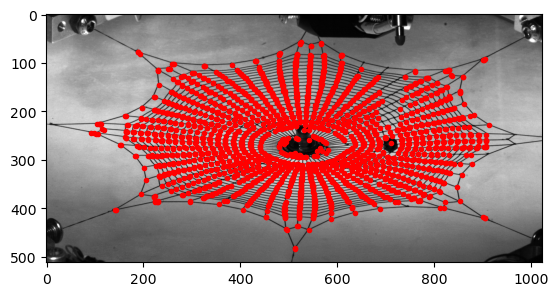

In [4]:
tp_lim = data['tracking points']
low_amplitude = np.max(np.linalg.norm(data['displacement'], axis=2),1)<25

td = data['displacement'] +  tp_lim.reshape(len(tp_lim),1,2)
play_video(video, range(1,5000), interval=30, points=td[low_amplitude, :, :])


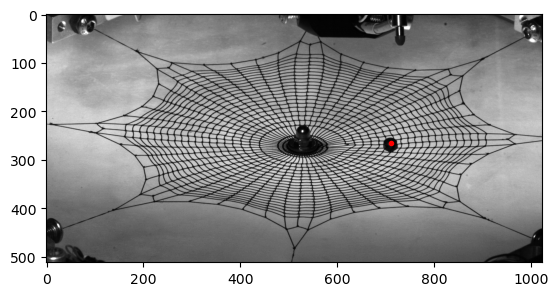

In [5]:
point = [265, 710 ]  # replace x and y with the coordinates of the point
# calculate the distances between the point and all points in tp_lim
distances = cdist([point], tp_lim)
# find the index of the nearest point
nearest_index = np.argmin(distances)
# get the coordinates of the nearest point
nearest_point = tp_lim[nearest_index]
play_video(video, range(1,5000), interval=30, points=td[nearest_index, :, :].reshape(1,-1,2))

In [6]:
%matplotlib qt
force_index = impact_data['NI']['channel_names'].index('Force')
accel_index = impact_data['NI']['channel_names'].index('Acceleration')
force = impact_data['NI']['data'][:,force_index]
accel = impact_data['NI']['data'][:,accel_index]

start_index = np.where(impact_data['NI']['time'] >= 1.5)[0][0]

impact_mean = np.mean(force[start_index:])
mean_accel = np.mean(accel[start_index:])

force -= impact_mean
accel = -(accel-mean_accel)/9.81

disp = data['displacement'][nearest_index, :, 0]


### Shift the time signals such that the match approximately

In [7]:
# Prepare Displacement signal
disp_peaks, _       = find_peaks(disp, height=0.5, distance=fs_camera*0.01)
threshold           = 0.001
near_zero_indices_cam   = np.where(disp[:disp_peaks[0]] < threshold)[0]
first_cam_near_zero_index = near_zero_indices_cam[-1]
t_camera2           = t_camera - t_camera[first_cam_near_zero_index]

time_cam_clipped    = t_camera2[first_cam_near_zero_index:]
disp_clipped        = disp[first_cam_near_zero_index:]


# Prepare Force signal
force_peaks, _      = find_peaks(force, height=0.5)
threshold           = 0.001
near_zero_indices_for   = np.where(force[:force_peaks[0]] < threshold)[0]
first_for_near_zero_index = near_zero_indices_for[-1]
t_force             = impact_data['NI']['time'] - impact_data['NI']['time'][first_for_near_zero_index]
t_force_index_end   = np.argmin(np.abs(t_force - t_camera2[-1]))

time_imp_clipped    = t_force[first_for_near_zero_index:t_force_index_end]
force_clipped       = force[first_for_near_zero_index:t_force_index_end]


In [10]:
fig, ax = plt.subplots()
plt.plot(t_force, force,'g-', label='Force')
plt.plot(t_force[force_peaks], force[force_peaks], 'gx')
plt.plot(t_force[first_near_zero_index], force[first_near_zero_index],'go')

# plt.plot(impact_time, accel_signal,'g--', label='Acceleration')
plt.xlabel('Time (s)')
plt.xlim([-0.05, t_camera[-1]+0.01])

ax.plot(t_camera2, disp,'r-', label='Displacement')
plt.plot(t_camera2[disp_peaks], disp[disp_peaks], 'rx')

plt.ylabel('pixels (-) or Force (N)')
plt.legend()
plt.show()

In [9]:
fig, ax = plt.subplots()
plt.plot(time_imp_clipped, force_clipped,'g-', label='Force')
plt.plot(time_cam_clipped, disp_clipped,'r-', label='Displacement')
n_d = len(disp_clipped)
n_f = len(force_clipped)
n_d, n_f

(9669, 31280)